# Lab 3: Building a Travel Planner with a Simple LangGraph

## Overview

This lab guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.


## Use Case Details

Our Travel Planner follows a straightforward, three-step process:

1. **Initial User Input**: 
   - The application prompts the user to enter their desired travel plan to get assistance from AI Agent.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

The below diagram illustrates this:

![Travel Planner Agent](./images/agents_itinerary.png)

In [ ]:

# %pip install -U --no-cache-dir  \
# langchain>=0.3.7 \ 
# langchain-anthropic>=0.1.15 \
# langchain-aws>=0.2.6 \
# langchain-community>=0.3.5 \
# langchain-core>=0.3.15 \
# langchain-text-splitters>=0.3.2 \
# langchainhub>=0.1.20 \
# langgraph>=0.2.45 \
# langgraph-checkpoint>=2.0.2 \
# langgraph-sdk>=0.1.35 \
# langsmith>=0.1.140 \
# sqlalchemy -U \
# "faiss-cpu>=1.7,<2" \
# "pypdf>=3.8,<4" \
# "ipywidgets>=7,<8" \
# matplotlib>=3.9.0 \

#%pip install -U --no-cache-dir transformers
#%pip install -U --no-cache-dir boto3
#%pip install grandalf==3.1.2

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
#load_dotenv()

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

### Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

In [3]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    interests: List[str]
    itinerary: str

### Set Up Language Model and Prompts


In [4]:
#llm = ChatOpenAI(model="gpt-4o-mini")

from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock
import boto3

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

llm = ChatBedrockConverse(
    model="anthropic.claude-3-sonnet-20240229-v1:0",
    # model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [5]:
def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. We build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above. Then, we add our nodes and edges. We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph. The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [6]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

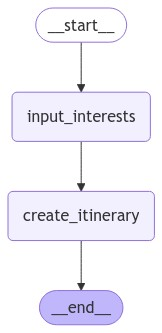

In [7]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [8]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "interests": [],
        "itinerary": "",
    }
    
    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

In [ ]:
user_request = "I want to plan a day trip to lake tahoe with my family. Need a complete plan"
run_travel_planner(user_request)

### Define Agent Nodes

Now we'll define the main functions nodes that our agent will use: get interests, create itinerary. [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above. Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`. Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

#### Memory Management
memory is key for any agentic conversation which is `Multi-Turn` or `Multi-Agent` colloboration conversation and more so if it spans multiple days. The 3 main aspects of Agents are:
1. Tools
2. Memory
3. Planners

![Agent memory](./images/agents_memory.png)

For Memory we further need short term and long term memory which can be explained below. Further reading can be at this ![link ](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)

![long term memory](./images/short-vs-long.png)

In [ ]:
### This below LEVARAGES the In-memory with multiple sessions and session id
store = {}
def get_session_history(session_id: str) -> BaseChatMessageHistory:
    #print(session_id)
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

chain = prompt | chatbedrock_llm | StrOutputParser()

wrapped_chain = RunnableWithMessageHistory(
    chain,
    get_session_history,
    history_messages_key="chat_history",
)

print_ww(wrapped_chain.invoke(
    {"input": "what is the weather like in Seattle WA"},
    config={"configurable": {"session_id": "abc123"}},
))

print("\n\n now ask another question and we will see the History conversation was maintained")
print_ww(wrapped_chain.invoke(
    {"input": "Ok what are benefits of this weather in 100 words?"},
    config={"configurable": {"session_id": "abc123"}},
))

print("\n\n now check the history")
print(history)

#### Now use with external memory management

In [ ]:
from langchain_aws.chat_models.bedrock import ChatBedrock
from langchain.agents import AgentExecutor, create_tool_calling_agent

from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate,HumanMessagePromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import requests

from langchain.tools import tool

from langchain.agents import AgentExecutor
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_aws.chat_models.bedrock_converse import ChatBedrockConverse

book_cancel_agent, agent_executor_book_cancel = None, None

def create_book_cancel_agent():

    @tool ("book_appointment")
    def book_appointment(date: str, time:str) -> dict:
        """Use this function to book an appointment. This function needs date and time as a string to books the appointment with the doctor. This function returns the booking id back which you must send to the user"""

        print(date, time)
        return {"status" : True, "date": date, "booking_id": "id_123"}
        
    @tool ("cancel_appointment")
    def cancel_appointment(booking_id: str) -> dict:
        """Use this function to cancel the appointment. This function needs a booking id to cancel the appointment with the doctor. This function returns the status of the booking and the booking id which you must return back to the user """

        print(booking_id)
        return {"status" : True, "booking_id": booking_id}

    @tool ("need_more_info")
    def need_more_info() -> dict:
        """Use this function to get more information from the user.  This function returns the date and time needed for the booking of appointment """

        return {"date": "August 11, 2024", "time": "11:00 am"}

    # BOTH prompt templates work -- 

    prompt_template_sys = """

    Use the following format:
    Question: the input question you must answer
    Thought: you should always think about what to do, Also try to follow steps mentioned above
    Action: the action to take, should be one of [ "book_appointment", "cancel_appointment"]
    Action Input: the input to the action\nObservation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Question: {input}

    Assistant:
    {agent_scratchpad}'

    """
    messages=[
        SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input'], template=prompt_template_sys)), 
        HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))
    ]

    chat_prompt_template = ChatPromptTemplate(
        input_variables=['agent_scratchpad', 'input'], 
        messages=messages
    )
    #print_ww(f"\nCrafted::prompt:template:{chat_prompt_template}")


    prompt_template_sys = """

    Use the following format:
    Question: the input question you must answer. 
    Thought: you should always think about what to do, Also try to follow steps mentioned above. If you need information do not make it up but return with "need_more_info"
    Action: the action to take, should be one of [ "book_appointment", "cancel_appointment", "need_more_info"]
    Action Input: the input to the action\nObservation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    """

    chat_prompt_template = ChatPromptTemplate.from_messages(
            messages = [
                ("system", prompt_template_sys),
                ("placeholder", "{chat_history}"),
                ("human", "{input}"),
                ("placeholder", "{agent_scratchpad}"),
            ]
    )

    #print_ww(f"\nCrafted::prompt:template:{chat_prompt_template}")

    modelId = "anthropic.claude-3-sonnet-20240229-v1:0" 

    model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 200}
    chat_bedrock_appointment = ChatBedrock(
        model_id=modelId,
        client=boto3_bedrock,
        model_kwargs=model_parameter, 
        beta_use_converse_api=True
    )


    tools_list_book = [ book_appointment, cancel_appointment, need_more_info]

    # Construct the Tools agent
    book_cancel_agent_t = create_tool_calling_agent(chat_bedrock_appointment, tools_list_book,chat_prompt_template)
    
    #return book_cancel_agent_t
    agent_executor_t = AgentExecutor(agent=book_cancel_agent_t, tools=tools_list_book, verbose=True, max_iterations=5, return_intermediate_steps=True)
    return book_cancel_agent_t, agent_executor_t

book_cancel_history = InMemoryChatMessageHistory()
book_cancel_history.add_user_message("can you book an appointment?")
book_cancel_history.add_ai_message("What is the date and time you wish for the appointment")
book_cancel_history.add_user_message("I need for August 10, 2024 at 10:00 am?")

user_query = "can you book an appointment for me?" # "can you book an appointment for me for August 10, 2024 at 10:00 am?"

if book_cancel_agent == None:
    book_cancel_agent, agent_executor_book_cancel = create_book_cancel_agent()
    
agent_executor_book_cancel.invoke(
    {"input": user_query, "chat_history": book_cancel_history.messages}, 
    config={"configurable": {"session_id": "session_1"}}
) # ['text']


## Conclusion

You have successfully executed a simple LangGraph implementation, this lab demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

Please proceed to the next lab